In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')
%matplotlib inline 

In [2]:
with open('test.txt', 'r') as myfile:
    data = myfile.read()

In [3]:
pages = data.split('[SAUCE_BREAK]')

In [4]:
def create_dataframe(pages):
    dataframe_rows = []
    for i, page in enumerate(pages, 1):
        dataframe_rows.append(('Page {}'.format(i), page))
    return pd.DataFrame(dataframe_rows, columns=['Page Id', 'Text'])

In [5]:
df = create_dataframe(pages)

In [6]:
df.head()

,Page Id,Text
0,Page 1,"ETH. Wilt thou, O God, fly from such gentle ..."
1,Page 2,"a star i' th' darkest night, Stick fiery o..."
2,Page 3,"raordinarily. If it be a hot day, and I bra..."
3,Page 4,York My princely father then had wars in ...
4,Page 5,u a more horrid hent. When he is drunk asle...


In [7]:
from gensim.parsing.preprocessing import strip_punctuation
from gensim.utils import simple_preprocess
from nltk.tokenize import sent_tokenize
import nltk

STOPWORDS = nltk.corpus.stopwords.words('english')

def tokenize(text):
    text = filter(lambda ch: ch in printable, text)
    return [token for token in simple_preprocess(strip_punctuation(text.strip())) if token not in STOPWORDS]

def tokenize_sentences(sentences):
    sent_tokens = []
    for sentence in sentences:
        tokens = [token for token in simple_preprocess(strip_punctuation(sentence.strip()))
                                                                      if token not in STOPWORDS]
        sent_tokens.append(tokens)
    return sent_tokens

In [8]:
import string
printable = set(string.printable)

cleaned_descriptions = df.copy()
cleaned_descriptions['Text'] = cleaned_descriptions['Text'].apply(
                lambda text: filter(lambda ch: ch in printable, text))
cleaned_descriptions['Tokens'] = cleaned_descriptions['Text'].apply(tokenize)
cleaned_descriptions['Sentence Tokens'] = cleaned_descriptions['Text'].apply(
                                                lambda text: tokenize_sentences(sent_tokenize(text)))

In [9]:
cleaned_descriptions.head()

,Page Id,Text,Tokens,Sentence Tokens
0,Page 1,"ETH. Wilt thou, O God, fly from such gentle ...","[eth, wilt, thou, god, fly, gentle, lambs, thr...","[[eth], [wilt, thou, god, fly, gentle, lambs, ..."
1,Page 2,"a star i' th' darkest night, Stick fiery o...","[star, th, darkest, night, stick, fiery, indee...","[[star, th, darkest, night, stick, fiery, inde..."
2,Page 3,"raordinarily. If it be a hot day, and I bra...","[raordinarily, hot, day, brandish, anything, b...","[[raordinarily], [hot, day, brandish, anything..."
3,Page 4,York My princely father then had wars in ...,"[york, princely, father, wars, france, true, c...","[[york, princely, father, wars, france, true, ..."
4,Page 5,u a more horrid hent. When he is drunk asle...,"[horrid, hent, drunk, asleep, rage, th, incest...","[[horrid, hent], [drunk, asleep, rage, th, inc..."


In [10]:
# Flatten our list of sentence tokens per document
sentences = [sent_tokens for document in cleaned_descriptions['Sentence Tokens'].tolist() 
                            for sent_tokens in document]

In [11]:
import gensim

w2v_model = gensim.models.Word2Vec(
            sentences,
            size=50,
            window=20,
            min_count=10,
            workers=4)
w2v_model.train(sentences, total_examples=len(sentences), epochs=30)

12851086

In [12]:
w2v_model.wv.most_similar(positive='york')

[(u'somerset', 0.7900512218475342),
 (u'lancaster', 0.7160382270812988),
 (u'buckingham', 0.7123672962188721),
 (u'humphrey', 0.7072060108184814),
 (u'bolingbroke', 0.6910154819488525),
 (u'suffolk', 0.6890754699707031),
 (u'northumberland', 0.6675142645835876),
 (u'protector', 0.6639373302459717),
 (u'plantagenet', 0.6599839925765991),
 (u'richard', 0.641930341720581)]

In [13]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=50):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summation_vec = np.sum(vectorized, axis=0)
    averaged = np.divide(summation_vec, length)
    return averaged

def get_word2vec_embeddings(vectors, df, generate_missing=False):
    embeddings = df['Tokens'].apply(lambda tokens: get_average_word2vec(tokens, vectors, 
                                                                       generate_missing=generate_missing))
    return list(embeddings)

In [14]:
# Generate Vector Representations of Roles
page2vec = get_word2vec_embeddings(w2v_model, cleaned_descriptions)

# Word2Vec T-SNE Transformation + K - Means Clustering

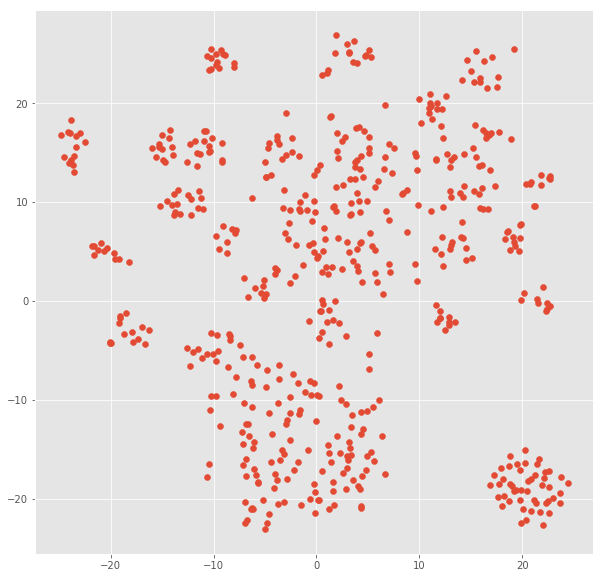

In [15]:
from sklearn.manifold import TSNE

dim_reducer = TSNE()
Z = dim_reducer.fit_transform(page2vec)

# Select the 0th feature: xs
xs = Z[:,0]

# Select the 1st feature: ys
ys = Z[:,1]

# Scatter plot, coloring by variety_numbers
plt.figure(figsize=(10, 10))
plt.scatter(xs, ys)
plt.show()

In [16]:
from sklearn.cluster import KMeans

model_tsne = KMeans(n_clusters=2, random_state=23)
model_tsne.fit(Z)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=23, tol=0.0001, verbose=0)

In [17]:
def compute_silhouette_score(data, k):
    model = KMeans(n_clusters=k, init='k-means++', random_state=23)
    cluster_labels = model.fit_predict(data)
    return silhouette_score(data, cluster_labels)

In [18]:
from sklearn.metrics import silhouette_score
print "Silhouette Score of Clustering with k=%d: %.3f" %(2,
                                                             compute_silhouette_score(Z, k=2))

Silhouette Score of Clustering with k=2: 0.412


## Cluster Visualization

In [19]:
def d(u, v):
    diff = u - v
    return diff.dot(diff)

def plot_k_means(X, M, K, beta=1.0, show_plots=True):
    N, _ = X.shape
    R = np.zeros((N, K))
    exponents = np.empty((N, K))
    print K
    print exponents.shape

    for k in xrange(K):
        for n in xrange(N):
            # R[n,k] = np.exp(-beta*d(M[k], X[n])) / np.sum( np.exp(-beta*d(M[j], X[n])) for j in xrange(K) )
            exponents[n,k] = np.exp(-beta*d(M[k], X[n]))

        R = exponents / exponents.sum(axis=1, keepdims=True)

    if show_plots:
        random_colors = np.random.random((K, 3))
        colors = R.dot(random_colors)
        plt.figure(figsize=(8, 8))
        plt.scatter(X[:,0], X[:,1], s=10, alpha=0.9, c=colors)
        

Silhouette Score of Clustering with k=4: 0.462
4
(570, 4)


/Users/talentsky/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in divide


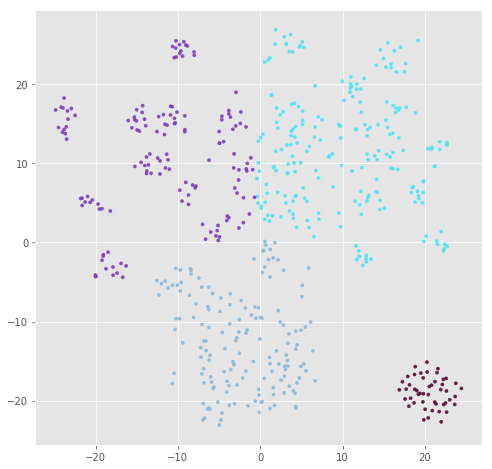

In [20]:
k = 4
model_tsne = KMeans(n_clusters=k, random_state=23)
model_tsne.fit(Z)
print "Silhouette Score of Clustering with k=%d: %.3f" %(k,
                                                             compute_silhouette_score(Z, k=k))
clusters = model_tsne.cluster_centers_
plot_k_means(Z[:,:2], clusters, k, show_plots=True)

This looks hopeful we have a cluster that is much smaller then the rest of clusters. Let's do further analysis.

In [21]:
cleaned_descriptions['Labels'] = model_tsne.predict(Z)

In [29]:
from collections import Counter

label_tops_words = []

for label_i in range(k):
    top_words = Counter(" ".join(
        cleaned_descriptions[cleaned_descriptions['Labels'] == label_i]['Tokens'].apply(" ".join)).split()
                       ).most_common(20)
    print "Cluster {} Size: {}".format(label_i + 1, (cleaned_descriptions['Labels'] == label_i).sum())
    label_tops_words.append(top_words)
print
print "Number of Documents: {}".format(len(df))

Cluster 1 Size: 48
Cluster 2 Size: 148
Cluster 3 Size: 156
Cluster 4 Size: 218

Number of Documents: 570


Cluster 1 has a size that is about 10% of the pages!

## Cluster 1 Top Words

In [23]:
label_tops_words[0]

[(u'case', 800),
 (u'said', 640),
 (u'like', 270),
 (u'molly', 260),
 (u'one', 242),
 (u'back', 198),
 (u'armitage', 165),
 (u'know', 161),
 (u'got', 160),
 (u'man', 153),
 (u'eyes', 151),
 (u'maelcum', 134),
 (u'get', 130),
 (u'black', 117),
 (u'white', 114),
 (u'something', 114),
 (u'riviera', 110),
 (u'finn', 108),
 (u'hand', 100),
 (u'face', 97)]

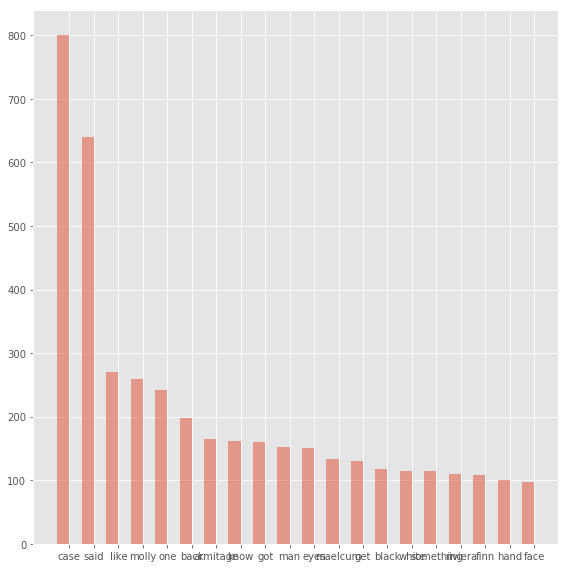

In [24]:
plt.figure(figsize=(8,8))
labels, values = zip(*label_tops_words[0])

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width, alpha = 0.5)
plt.xticks(indexes + width * 0.5, labels)
plt.tight_layout()

The top words of this cluster appears to be more similar to a modern english style of writing.

## Cluster 2 Top Words

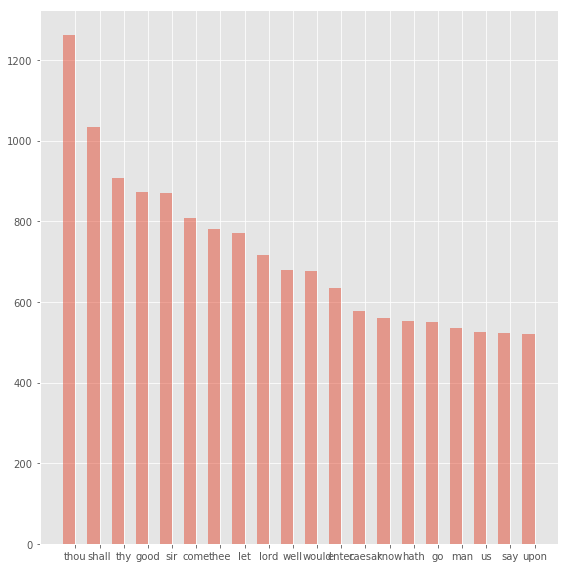

In [25]:
plt.figure(figsize=(8,8))
labels, values = zip(*label_tops_words[1])

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width, alpha = 0.5)
plt.xticks(indexes + width * 0.5, labels)
plt.tight_layout()

## Cluster 3 Top Words

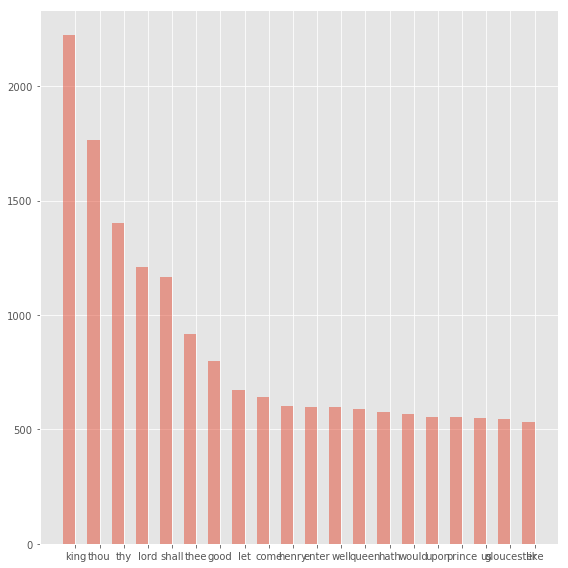

In [31]:
plt.figure(figsize=(8,8))
labels, values = zip(*label_tops_words[2])

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width, alpha = 0.5)
plt.xticks(indexes + width * 0.5, labels)
plt.tight_layout()

## Cluster 4 Top Words

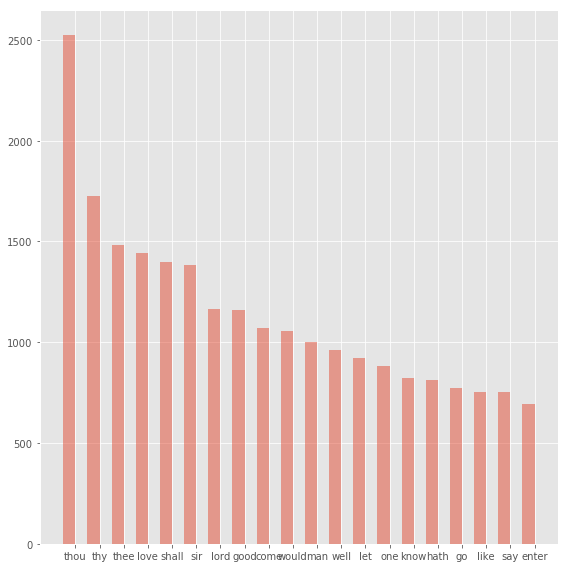

In [27]:
plt.figure(figsize=(8,8))
labels, values = zip(*label_tops_words[3])

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width, alpha = 0.5)
plt.xticks(indexes + width * 0.5, labels)
plt.tight_layout()

As we can see above, the top words for clusters 2-4 are more similar to the writing style of Skakespeare.

# Further Work

- Come out with evaluation methods to see how well our embedding model is performing. This may improve silhouette coefficient score, which is a metric measures how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.